# **Predict Health Insurance Owners' who will be interested in Vehicle Insurance**

An insurance company that has provided Health Insurance to its customers want to build a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.

In [ ]:
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Load the Data**

In [ ]:
#Importing Data Set
df = pd.read_csv('/content/drive/MyDrive/train.csv')

# **View the data**

In [ ]:
#View the data
df.head(10)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
5,6,Female,24,1,33.0,0,< 1 Year,Yes,2630.0,160.0,176,0
6,7,Male,23,1,11.0,0,< 1 Year,Yes,23367.0,152.0,249,0
7,8,Female,56,1,28.0,0,1-2 Year,Yes,32031.0,26.0,72,1
8,9,Female,24,1,3.0,1,< 1 Year,No,27619.0,152.0,28,0
9,10,Female,32,1,6.0,1,< 1 Year,No,28771.0,152.0,80,0


In [ ]:
display(f'Number of rows (clients): {df.shape[0]}')
display(f'Number of columns (characteristics): {df.shape[1]}')

'Number of rows (clients): 381109'

'Number of columns (characteristics): 12'

In [ ]:
df.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


# **Data Cleaning**

In [ ]:
# drop id column
df = df.drop('id',axis=1)

In [ ]:
# check missing values in train set
df.isnull().sum()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

no missing data
nothing to replace

In [ ]:
# check for duplicated data in train set
df.duplicated().any()

True

no duplicated data
nothing to remove

# **Data exploration**

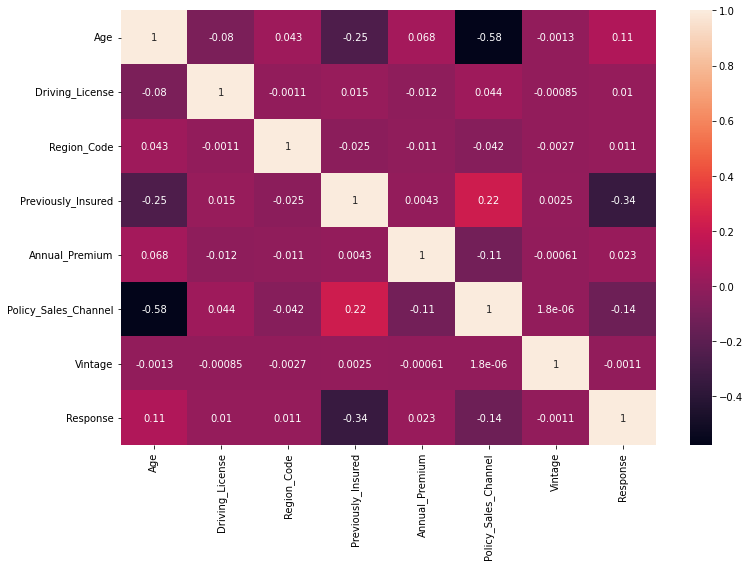

In [ ]:
#Plotting a diagonal correlation matrix

correlation_matrix = df.corr()

plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix,annot=True)

In [ ]:
hig_corr_features = correlation_matrix.index[abs(correlation_matrix["Response"]) >= 0.2]
hig_corr_features

Index(['Previously_Insured', 'Response'], dtype='object')

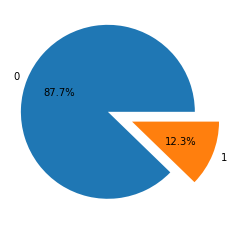

In [ ]:
plt.pie(df['Response'].value_counts(),labels=df['Response'].value_counts().index,autopct="%0.1f%%",explode=[0.1,0.2],radius=1);

There is class imbalance in the target variable


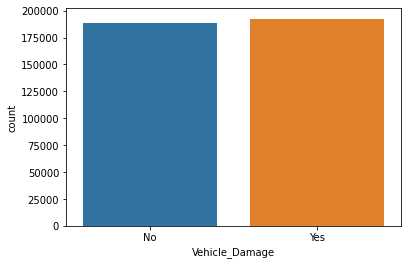

In [ ]:
vehicle_Damage=df.groupby('Vehicle_Damage')['Response'].mean()
sns.countplot(x='Vehicle_Damage',data=df,order=vehicle_Damage.index);

People with previously damaged vehicels have much higher chances of buying insurance.

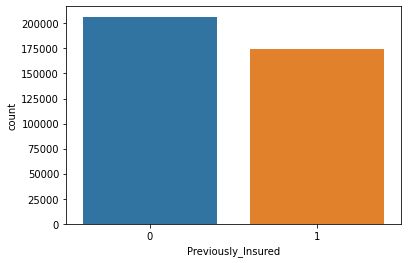

In [ ]:
previously_Insured=df.groupby('Previously_Insured')['Response'].mean()
sns.countplot(x='Previously_Insured',data=df,order=previously_Insured.index);

The majority of respondents who shown interest in insurance,do not have their vehicles insured previously.

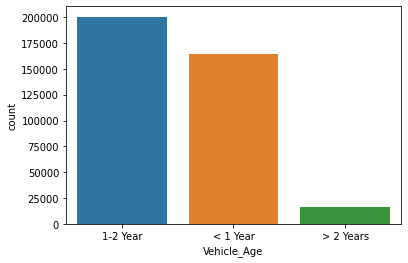

In [ ]:
vehicle_Age=df.groupby('Vehicle_Age')['Response'].mean()
sns.countplot(x='Vehicle_Age',data=df,order=vehicle_Age.index);

respondents with vehicule age of 0-2 show greater interest.

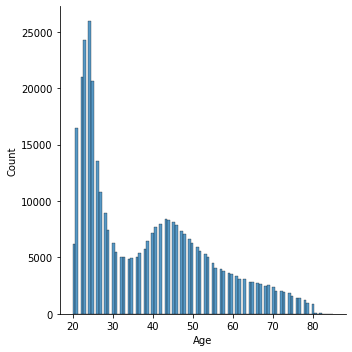

In [ ]:
#Age Distribution of Customers
sns.displot(df.Age)

Age variable has non gaussian distribution

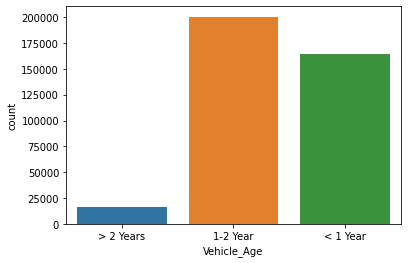

In [ ]:
#Vehicle Age
sns.countplot(x=df.Vehicle_Age)

# **Data Preprocessing**

In [ ]:
df['Vehicle_Age'].unique() 

array(['> 2 Years', '1-2 Year', '< 1 Year'], dtype=object)

In [ ]:
#Convert categorical data into numerical data
df['Vehicle_Age'] = df['Vehicle_Age'].replace(['> 2 Years','1-2 Year','< 1 Year'],[2,1,0])
df['Gender'] = df['Gender'].replace(['Male','Female'],[1,2])
df['Vehicle_Damage'] = df['Vehicle_Damage'].replace(['Yes','No'],[1,0])
df['Response'] = df['Response'].replace(['Yes','No'],[1,0])

In [ ]:
#Scaling Numeric Data
numeric_cols=['Age','Region_Code','Annual_Premium','Policy_Sales_Channel','Vintage']
df[numeric_cols] = MinMaxScaler().fit_transform(df[numeric_cols])

In [ ]:
df.describe()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,1.459239,0.289578,0.997869,0.507477,0.458210,0.609616,0.504877,0.051968,0.685397,0.499472,0.122563
std,0.498336,0.238640,0.046110,0.254421,0.498251,0.567439,0.499977,0.032022,0.334593,0.289520,0.327936
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.076923,1.000000,0.288462,0.000000,0.000000,0.000000,0.040509,0.172840,0.249135,0.000000
50%,1.000000,0.246154,1.000000,0.538462,0.000000,1.000000,1.000000,0.054023,0.814815,0.498270,0.000000
75%,2.000000,0.446154,1.000000,0.673077,1.000000,1.000000,1.000000,0.068405,0.932099,0.750865,0.000000
max,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Data Modelling**


In [ ]:
#Divide the data into “attributes” and “labels”
X = df.drop('Response',axis=1) #separate the other attributes from the predicting attribute
y = df['Response']

In [ ]:
# transform the dataset to solve the imblance problem with SMOTE technique
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% training and 20% test

In [ ]:
# Initialize RandomForest model object
model = RandomForestClassifier(class_weight='balanced')

# Train model on training set
model.fit(X_train, y_train)

# Evaluate model on test set
preds = model.predict(X_test)

**Model Evaluation**

In [ ]:
# show classification evaluation metrics
print(metrics.classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.93      0.88      0.91     66775
           1       0.89      0.94      0.91     66985

    accuracy                           0.91    133760
   macro avg       0.91      0.91      0.91    133760
weighted avg       0.91      0.91      0.91    133760



**Precision:**
Out of all the clients that the model predicted would be interested in insurance, 
89% are actually interested.
Out of all the clients that model predicted would not be interested in insurance, 93% are not.

**Recall:**
Out of all the customers that are actually interested in insurance, the model predicted the outcome correctly for 94% of them.
Out of all the customers that are actually not interested in insurance, the model predicted this outcome correctly for 88% of them.

**F1-score:**
Since the F1-score value of our model is very close to 1, it 
tells us that the model does a good job of predicting whether or not a customer 
will be interested in an insurance or not.

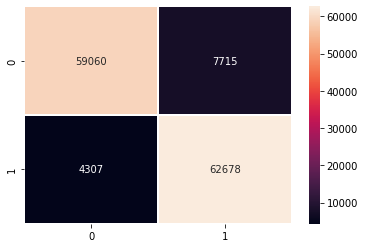

In [ ]:
# show confusion matrix
cm = metrics.confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5)

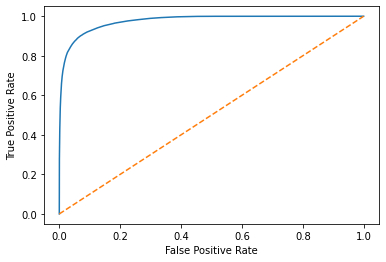

In [ ]:
#ROC Curve Random forest classifier
y_score = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_score)

#create ROC curve
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], ls="--")

plt.show()

**ROC curve:**
The curve of our Classifier is closer to the upper left corner 
that indicate a better performance. The value of the Y axis is higher, which indicates a greater number of true positives than 
false negatives